In [1]:
import os
import pickle

import numpy as np
import torch

import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, random_split
from torch.nn.functional import one_hot

from data_loaders.pulja_data_loader import PuljaDataLoader
from models._dkt import UserModel
from models.utils import collate_fn

if torch.cuda.is_available():
    from torch.cuda import FloatTensor, LongTensor
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
else:
    from torch import FloatTensor, LongTensor

In [2]:
ckpt_path = "ckpts"
if not os.path.isdir(ckpt_path):
    os.mkdir(ckpt_path)

batch_size = 256
num_epochs = 100
train_ratio = 0.9

seq_len = 100

dim_v = 20

dataset = PuljaDataLoader(seq_len)

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

model = UserModel(dataset.num_c, dataset.num_d, dim_v).to(device)

train_size = int(len(dataset) * train_ratio)
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(
    dataset, [train_size, test_size]
)

if os.path.exists(os.path.join(dataset.dataset_dir, "indices.pkl")):
    with open(os.path.join(dataset.dataset_dir, "indices.pkl"), "rb") as f:
        indices = pickle.load(f)
    train_dataset.indices = indices[0]
    test_dataset.indices = indices[1]
else:
    with open(os.path.join(dataset.dataset_dir, "indices.pkl"), "wb") as f:
        pickle.dump((train_dataset.indices, test_dataset.indices), f)


In [3]:
model.load_state_dict(
    torch.load(
        os.path.join(
            os.path.join(
                ckpt_path, "_dkt"
            ),
            "model_max.ckpt"
        ),
        map_location=device
    )
)
model.eval()

UserModel(
  (X): Embedding(259, 20)
  (gru): GRU(40, 20, batch_first=True)
  (out_layer): Linear(in_features=20, out_features=259, bias=True)
  (dropout_layer): Dropout(p=0.5, inplace=False)
)

In [4]:
aucs_list = []
max_aucs = []

dir_list = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10"]

for i in dir_list:
    with open(
        os.path.join(
            os.path.join(
                ckpt_path,
                os.path.join("_dkt", i)
            ),
            "aucs.pkl"
        ),
        "rb"
    ) as f:
        aucs = pickle.load(f)
    
    max_auc = np.max(aucs)

    aucs_list.append(aucs)
    max_aucs.append(max_auc)

In [5]:
print("max_aucs: {}".format(max_aucs))
print("max_auc_mean: {}, max_auc_std: {}".format(np.mean(max_aucs), np.std(max_aucs)))
print("max_auc_dir: {}".format(dir_list[np.argmax(max_aucs)]))

max_aucs: [0.8043878259595076, 0.8028549120933421, 0.8046517714050393, 0.801618582839808, 0.802153516071091, 0.8039241537139529, 0.8048438371329939, 0.8034797871934191, 0.8037519313770178, 0.8035734894223522]
max_auc_mean: 0.8035239807208523, max_auc_std: 0.0009966460127574935
max_auc_dir: 07


In [6]:
test_dataset[100]

(array([14, 14, 14, 14, 14, 14, 14, 21, 21, 21, 14, 14, 14, 14, 14, 14, 14,
        14, 21, 21, 21, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
        14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
        21, 21, 21, 21, 21, 21, 21, 21, 17, 17, 17, 17, 17, 17, 21, 21, 21,
        21, 21, 21, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 14, 14, 14, 17,
        17, 21, 21, 21, 21, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17]),
 array([3, 4, 3, 3, 3, 3, 3, 2, 2, 3, 2, 2, 2, 3, 2, 3, 2, 3, 2, 2, 3, 2,
        3, 2, 3, 2, 3, 4, 4, 2, 3, 3, 3, 4, 2, 3, 4, 4, 3, 3, 4, 3, 4, 3,
        2, 3, 4, 4, 4, 3, 2, 2, 2, 3, 2, 2, 3, 2, 2, 2, 3, 4, 4, 2, 3, 3,
        2, 3, 3, 2, 3, 2, 3, 3, 2, 2, 4, 4, 2, 3, 4, 3, 3, 3, 2, 2, 2, 3,
        3, 4, 2, 4, 2, 3, 3, 2, 2, 3, 3, 3, 4]),
 array([0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0.,
        1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 0., 1., 0.,
        1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1

In [7]:
# 3등급 전처리: 0, 2, 3, 4, 5, 7, 8, 9, 10, 13, 19, 21, 100, 101
# basis = 1.0: 0, 2, 4, 6, 7
# basis = 0.5: 0, 2, 3, 7
# 임의 전처리 01: 0, 2, 100
# 임의 전처리 02: 0, 3, 4, 5, 19
# 임의 전처리 03: 5, 9, 16, 19, 28, 100
c_seq, d_seq, r_seq = test_dataset[100]

c_seq, cshft_seq, d_seq, dshft_seq, r_seq, rshft_seq = \
[c_seq[:-1]], [c_seq[1:]], [d_seq[:-1]], [d_seq[1:]], [r_seq[:-1]], [r_seq[1:]]

# r_seq = np.zeros_like(r_seq)
# r_seq = np.ones_like(r_seq)

# d_seq = np.ones_like(d_seq) * 0

###########################################
# alpha_seq, beta_seq, beta_shft_seq, gamma_seq, gamma_shft_seq, h_seq, C_seq = model(
#     LongTensor(c_seq),
#     LongTensor(cshft_seq),
#     LongTensor(d_seq),
#     LongTensor(dshft_seq),
#     FloatTensor(r_seq),
# )
###########################################
# alpha_seq, h_seq, C_seq = model(
#     LongTensor(c_seq),
#     LongTensor(d_seq),
#     FloatTensor(r_seq),
# )

# # c_one_hot_seq: [batch_size, seq_len, 1, num_c]
# c_one_hot_seq = one_hot(LongTensor(c_seq), model.num_c).float()
# c_one_hot_seq = torch.reshape(
#     c_one_hot_seq,
#     shape=[
#         -1,
#         c_one_hot_seq.shape[1],
#         c_one_hot_seq.shape[2]
#     ]
# ).unsqueeze(-2)
# beta_seq = torch.bmm(
#     torch.reshape(
#         c_one_hot_seq,
#         shape=[
#             -1,
#             c_one_hot_seq.shape[2],
#             c_one_hot_seq.shape[3]
#         ]
#     ),
#     torch.reshape(
#         C_seq, shape=[-1, C_seq.shape[2], C_seq.shape[3]]
#     )
# )
# beta_seq = torch.reshape(
#     beta_seq, shape=[1, seq_len]
# )

# gamma_seq = model.D1(LongTensor(d_seq)).squeeze()
###########################################
alpha_seq, h_seq = model(
    LongTensor(c_seq),
    LongTensor(d_seq),
    FloatTensor(r_seq),
)
alpha_seq = alpha_seq.squeeze()

C_seq = alpha_seq.mean(-1)
alpha_seq = C_seq.mean(-1)
###########################################

sigmoid_alpha_seq = torch.sigmoid(alpha_seq).detach().cpu().numpy()

# sigmoid_alpha_beta_seq = torch.sigmoid(alpha_seq + beta_seq).detach().cpu().numpy()[0]

# sigmoid_alpha_beta_gamma_seq = torch.sigmoid(alpha_seq + beta_seq - gamma_seq).detach().cpu().numpy()[0]

r_seq_ma = np.cumsum(r_seq[0]) / np.arange(1, r_seq[0].shape[0] + 1)

CQ_seq = torch.sigmoid(C_seq.squeeze() + alpha_seq.unsqueeze(-1)).detach().cpu().numpy()
C_seq = C_seq.squeeze().detach().cpu().numpy()

# alpha_seq = alpha_seq.detach().cpu().numpy()

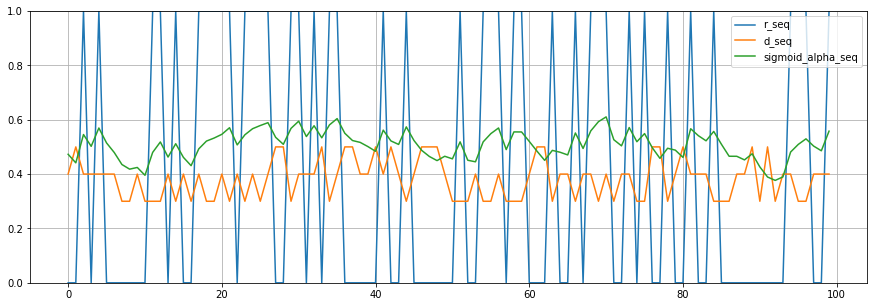

In [8]:
plt.figure(figsize=[15, 5], facecolor="white")
plt.plot(r_seq[0], label="r_seq")
plt.plot((d_seq[0] + 1) / 10, label="d_seq")
plt.plot(sigmoid_alpha_seq, label="sigmoid_alpha_seq")
# plt.plot(sigmoid_alpha_beta_seq, label="sigmoid_alpha_beta_seq")
# plt.plot(sigmoid_alpha_beta_gamma_seq, label="sigmoid_alpha_beta_gamma_seq")
# plt.plot(r_seq_ma, label="r_seq_ma")
plt.grid()
plt.ylim(0, 1)
plt.legend()
plt.show()

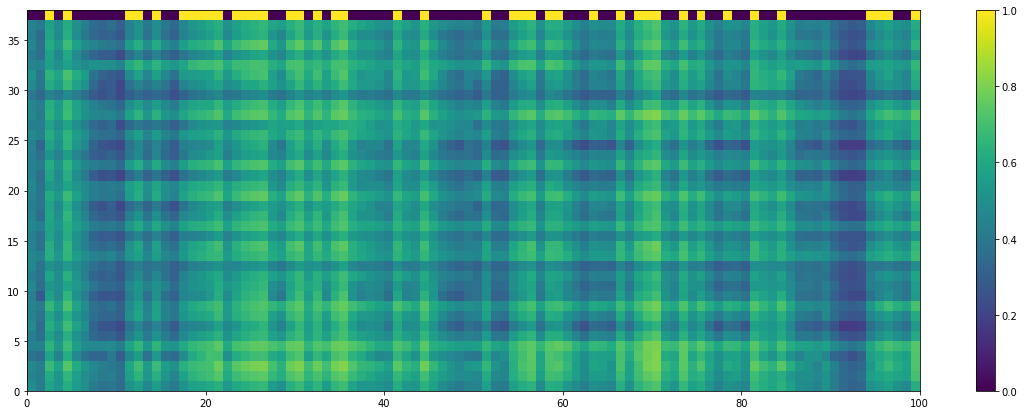

In [9]:
plt.figure(figsize=[20, 7], facecolor="white")
temp = np.concatenate([CQ_seq.T, r_seq], axis=0)
plt.pcolormesh(temp)
plt.colorbar()
plt.show()

# plt.figure(figsize=[15, 0.5], facecolor="white")
# plt.pcolormesh(r_seq)
# plt.show()

In [10]:
CQ_seq[0], CQ_seq[-1], c_seq, d_seq

(array([0.48813444, 0.4544721 , 0.46900108, 0.38244018, 0.43419188,
        0.4246122 , 0.47595772, 0.44770196, 0.4569429 , 0.42233098,
        0.4611943 , 0.41993955, 0.466872  , 0.46800774, 0.4384809 ,
        0.4338002 , 0.46635348, 0.4391982 , 0.4264253 , 0.4449917 ,
        0.46573332, 0.43934977, 0.44256398, 0.4196003 , 0.43439758,
        0.47033453, 0.42258114, 0.46800512, 0.46185085, 0.399039  ,
        0.47561055, 0.5024604 , 0.45299175, 0.4107122 , 0.4519948 ,
        0.42326203, 0.44401845], dtype=float32),
 array([0.6237461 , 0.7043915 , 0.7207161 , 0.72331625, 0.73221666,
        0.60388136, 0.5426373 , 0.6084666 , 0.70701   , 0.54628915,
        0.55829245, 0.5830282 , 0.48795566, 0.6814637 , 0.65416217,
        0.5235138 , 0.6641892 , 0.5683644 , 0.61881405, 0.6891118 ,
        0.56682366, 0.50269496, 0.6571656 , 0.5855151 , 0.48480085,
        0.6270859 , 0.6242546 , 0.73602945, 0.63915515, 0.43574604,
        0.60000676, 0.61822915, 0.66218525, 0.5125002 , 0.64550245,